In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objs as go

In [32]:
# Download Bitcoin data
data = yf.download(tickers='BTC-USD', start='2021-01-01', end='2024-12-15', interval = '1d')

# Reset index and have date as a column
data.reset_index(inplace=True)
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
print(data.columns)

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

[*********************100%***********************]  1 of 1 completed

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


,Date,Close,High,Low,Open,Volume
0,2021-01-01,"$29,374.15","$29,600.63","$28,803.59","$28,994.01",40730301359
1,2021-01-02,"$32,127.27","$33,155.12","$29,091.18","$29,376.46",67865420765
2,2021-01-03,"$32,782.02","$34,608.56","$32,052.32","$32,129.41",78665235202
3,2021-01-04,"$31,971.91","$33,440.22","$28,722.76","$32,810.95",81163475344
4,2021-01-05,"$33,992.43","$34,437.59","$30,221.19","$31,977.04",67547324782


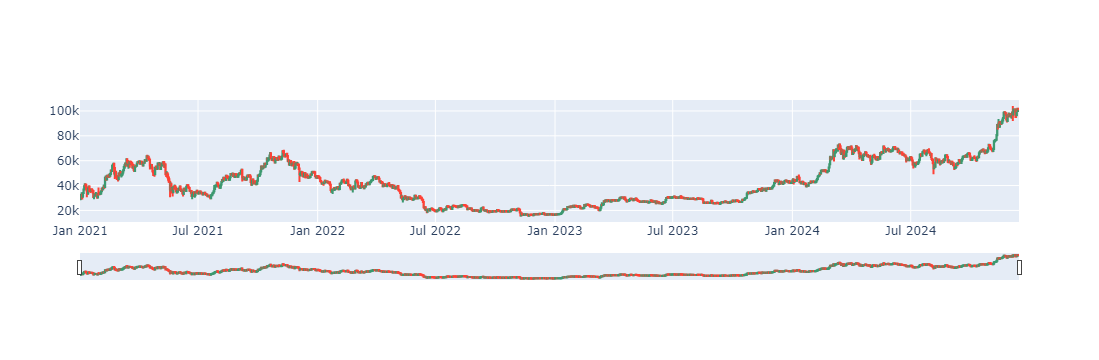

In [33]:
# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

In [34]:
# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename (columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Take a look at the data
df.head ()

,ds,y
0,2021-01-01,"$29,374.15"
1,2021-01-02,"$32,127.27"
2,2021-01-03,"$32,782.02"
3,2021-01-04,"$31,971.91"
4,2021-01-05,"$33,992.43"


In [35]:
df.tail()

,ds,y
1439,2024-12-10,"$96,675.43"
1440,2024-12-11,"$101,173.03"
1441,2024-12-12,"$100,043.00"
1442,2024-12-13,"$101,459.26"
1443,2024-12-14,"$101,372.97"


In [36]:
df.describe()

,ds,y
count,1444,"$1,444.00"
mean,2022-12-23 12:00:00,"$41,981.82"
min,2021-01-01 00:00:00,"$15,787.28"
25%,2021-12-27 18:00:00,"$27,224.21"
50%,2022-12-23 12:00:00,"$39,481.53"
75%,2023-12-19 06:00:00,"$57,035.99"
max,2024-12-14 00:00:00,"$101,459.26"
std,NaN,"$17,941.94"


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1444 non-null   datetime64[ns]
 1   y       1444 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.7 KB


In [38]:
df.isnull().any()

ds    False
y     False
dtype: bool

In [39]:
df.isnull().sum()

ds    0
y     0
dtype: int64

In [54]:
# Train test split
df_train = df[df['ds']<='2024-10-31']
df_test = df[df['ds']>'2024-10-31']

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 1400 records, ranging from 2021-01-01 00:00:00 to 2024-10-31 00:00:00
The testing dataset has 44 records, ranging from 2024-11-01 00:00:00 to 2024-12-14 00:00:00


In [57]:
m = Prophet(
seasonality_mode="multiplicative"
)
m.fit(df)

20:18:15 - cmdstanpy - INFO - Chain [1] start processing
20:18:15 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future = m.make_future_dataframe (periods = 365)
future.tail(365)

,ds
1444,2024-12-15
1445,2024-12-16
1446,2024-12-17
1447,2024-12-18
1448,2024-12-19
...,...
1804,2025-12-10
1805,2025-12-11
1806,2025-12-12
1807,2025-12-13


In [60]:
# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1804,2025-12-10,"$144,071.02","$99,914.43","$186,374.69"
1805,2025-12-11,"$143,134.18","$99,058.60","$183,946.84"
1806,2025-12-12,"$142,804.68","$98,472.43","$185,534.12"
1807,2025-12-13,"$142,153.90","$98,954.03","$185,561.23"
1808,2025-12-14,"$141,526.64","$97,329.90","$181,498.38"


In [61]:
next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
forecast [forecast['ds'] == next_day] ['yhat'].item()

90290.39791286757

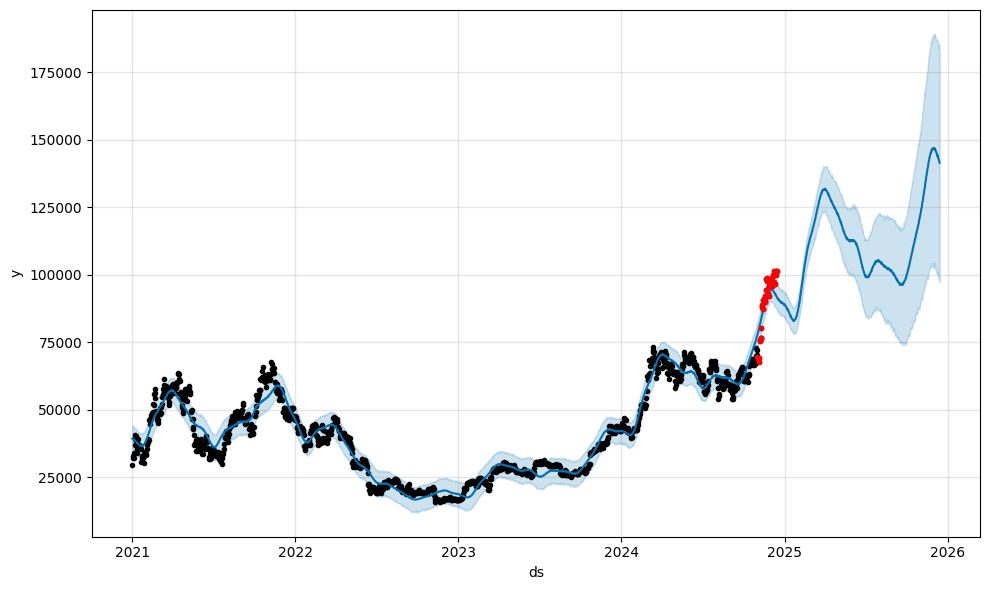

In [65]:
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

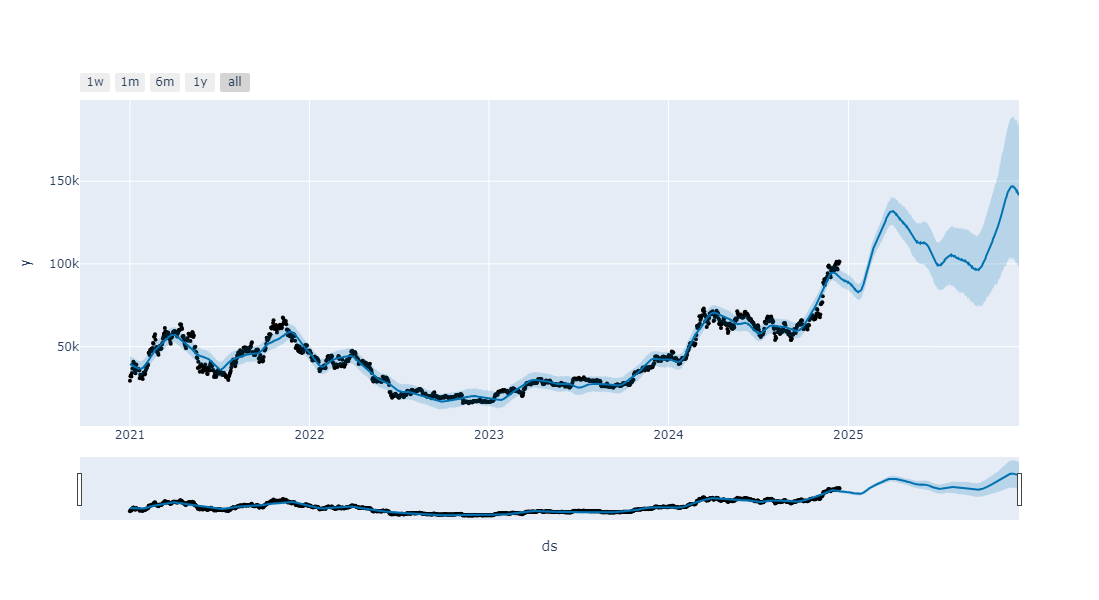

In [66]:
plot_plotly(m, forecast)

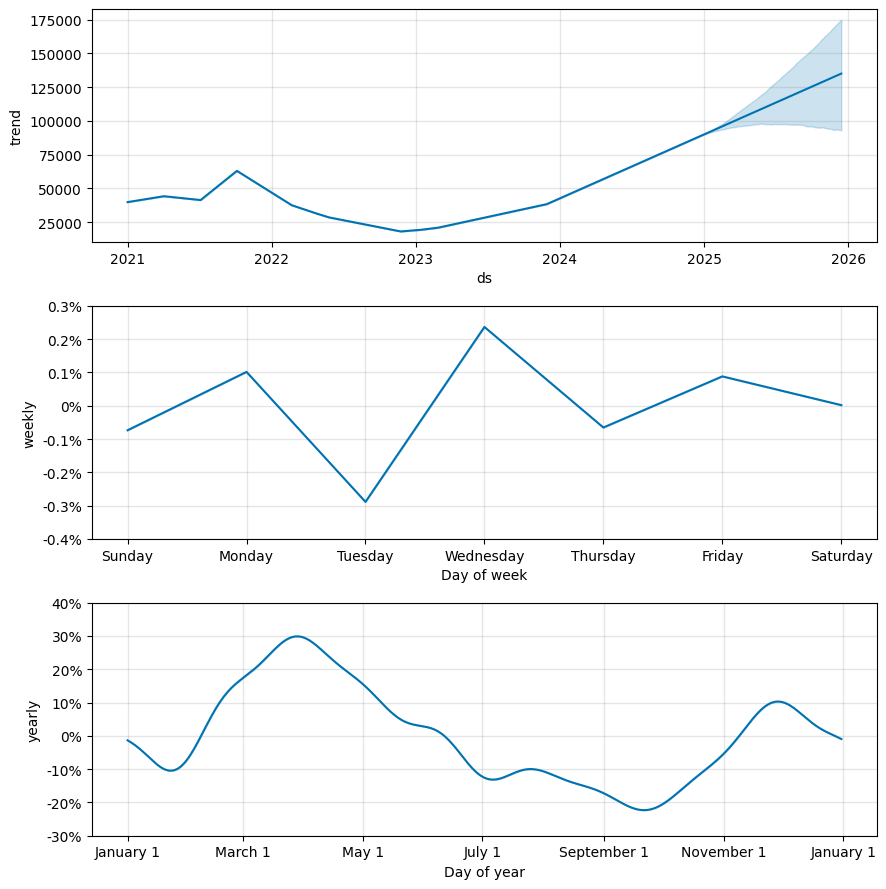

In [76]:
# Visualize the components
m.plot_components(forecast);

In [77]:
# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-05-30,"$24,168.54","$20,999.61","$27,321.06","$31,726.39",2022-05-29
1,2022-05-31,"$23,919.22","$20,777.25","$27,187.32","$31,792.31",2022-05-29
2,2022-06-01,"$23,850.75","$20,746.52","$27,183.20","$29,799.08",2022-05-29
3,2022-06-02,"$23,530.52","$19,983.97","$26,929.12","$30,467.49",2022-05-29
4,2022-06-03,"$23,418.46","$19,938.06","$26,545.43","$29,704.39",2022-05-29


In [78]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [79]:
r2_score(df_cv.y, df_cv.yhat)

0.8113777247976612

In [80]:
mean_squared_error(df_cv.y, df_cv.yhat)

96943459.99548067

In [81]:

mean_absolute_error(df_cv.y, df_cv.yhat)

7543.718568648439

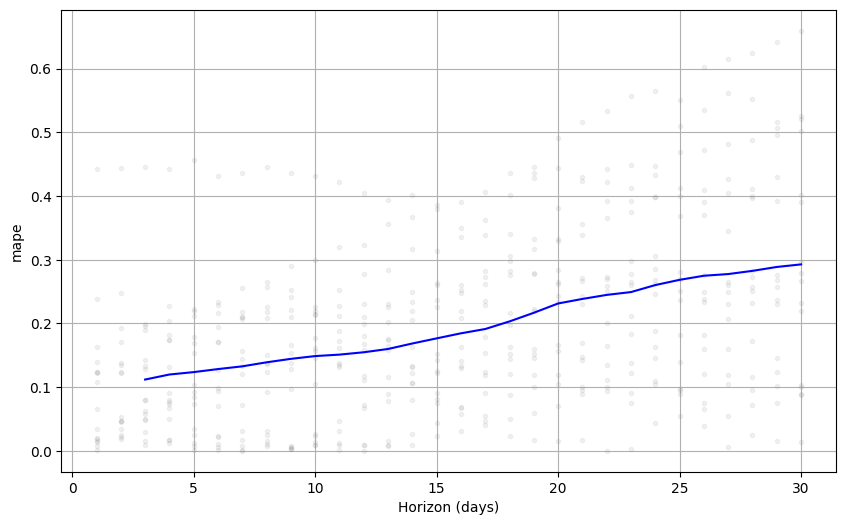

In [82]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [83]:
import pickle
pickle.dump(m,open('fbcrypto.pkl','wb'))

In [86]:
pickle.dump(m, open(r'C:\Users\lenovo\OneDrive\Desktop\github\time series anaysis bitcoin price\time series analysis\flask\fbcrypto.pkl', 'wb'))
